<a href="https://colab.research.google.com/github/mauricef/mauricef.github.io/blob/main/jax-ml/sliced_optimal_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sliced Optimal Transport
From https://colab.research.google.com/github/znah/notebooks/blob/master/sliced_optimal_transport.ipynb

In [1]:
from functools import partial

from IPython import display

from jax import nn, lax, random, vmap, value_and_grad
import jax.numpy as jp

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

rng = random.PRNGKey(42)

In [2]:
def project(a, b):
    return jp.dot(a, b) / jp.linalg.norm(b)

def ot_cost_1d(points, targets):
    return .5 * jp.square(points.sort() - targets.sort()).sum()

def ot_cost_proj(points, targets, proj):
    _project = vmap(lambda point: project(point, proj))
    return ot_cost_1d(_project(points), _project(targets))

def sliced_ot_cost(points, targets, rng, nprojections):
    ndims = points.shape[1]
    projs = random.normal(rng, (nprojections, ndims))
    _ot_cost_proj = vmap(lambda proj: ot_cost_proj(points, targets, proj))
    return _ot_cost_proj(projs).mean()

In [3]:
ndims = 2
nsteps = 75
npoints = 32
nprojections = 64
learning_rate = 1.

rng, r = random.split(rng)
targets = 2. * random.normal(rng, [npoints, ndims]) + 1.
rng, r = random.split(rng)
points = random.normal(rng, [npoints, ndims])

grad_fn = value_and_grad(partial(sliced_ot_cost, targets=targets, nprojections=nprojections))

def step(points, r):
    loss, grads = grad_fn(points, rng=rng)
    next_points = points - learning_rate * grads
    return next_points, (points, loss)

rngs = jp.array(random.split(rng, nsteps))
_, (trajectory, loss) = lax.scan(step, points, xs=rngs)

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
fig.tight_layout()
x, y = targets.T
ax.plot(x, y, '.', color='blue')
x, y = points.T
ax.plot(x, y, '.', color='red', alpha=.5);
xlim, ylim = ax.get_xlim(), ax.get_ylim()

last_plot = None
def animate(frame):
    global last_plot
    if last_plot is not None:
        last_plot[0].remove()
    points = trajectory[frame]
    prev_points = trajectory[frame - 1] if frame > 0 else None
    if prev_points is not None:
        lines = LineCollection(jp.stack([prev_points, points], 1), alpha=0.5)
        ax.add_collection(lines)
    x, y = points.T
    last_plot = ax.plot(x, y, '.', color='red', alpha=.5);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return last_plot

anim = FuncAnimation(fig, animate, frames=nsteps)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

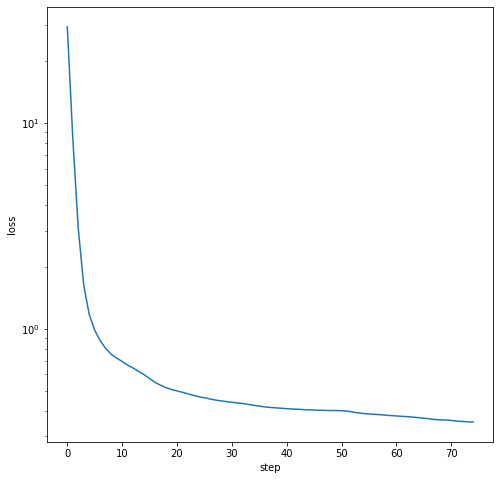

In [5]:
plt.figure(figsize=(8, 8))
plt.plot(loss)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('loss')
plt.show()